In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
import torch
import cellij
import numpy as np
from pyro.nn import PyroModule
import pyro.distributions as dist



/Users/tim.treis/anaconda3/envs/spatialdata/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [4]:
model = cellij.core.models.MOFA(n_factors=50)
model.add_data(data=mdata, na_strategy="knn_by_obs")

In [5]:
model.fit(likelihood="Normal",  epochs=1000, verbose_epochs=50)

Epoch      0:     7512671.82
Epoch     50:     5074198.58
Epoch    100:     4270343.76
Epoch    150:     3881320.40
Epoch    200:     3676838.54
Epoch    250:     3549969.76
Epoch    300:     3482589.51
Epoch    350:     3442513.87
Epoch    400:     3415208.28
Epoch    450:     3399387.15
Epoch    500:     3386927.18
Epoch    550:     3376595.58
Epoch    600:     3368820.99
Epoch    650:     3363629.56
Epoch    700:     3362133.23
Epoch    750:     3359600.67
Epoch    800:     3353423.09
Epoch    850:     3352382.67
Epoch    900:     3349855.79
Epoch    950:     3348194.24
Epoch   1000:     3348819.83


<AxesSubplot:>

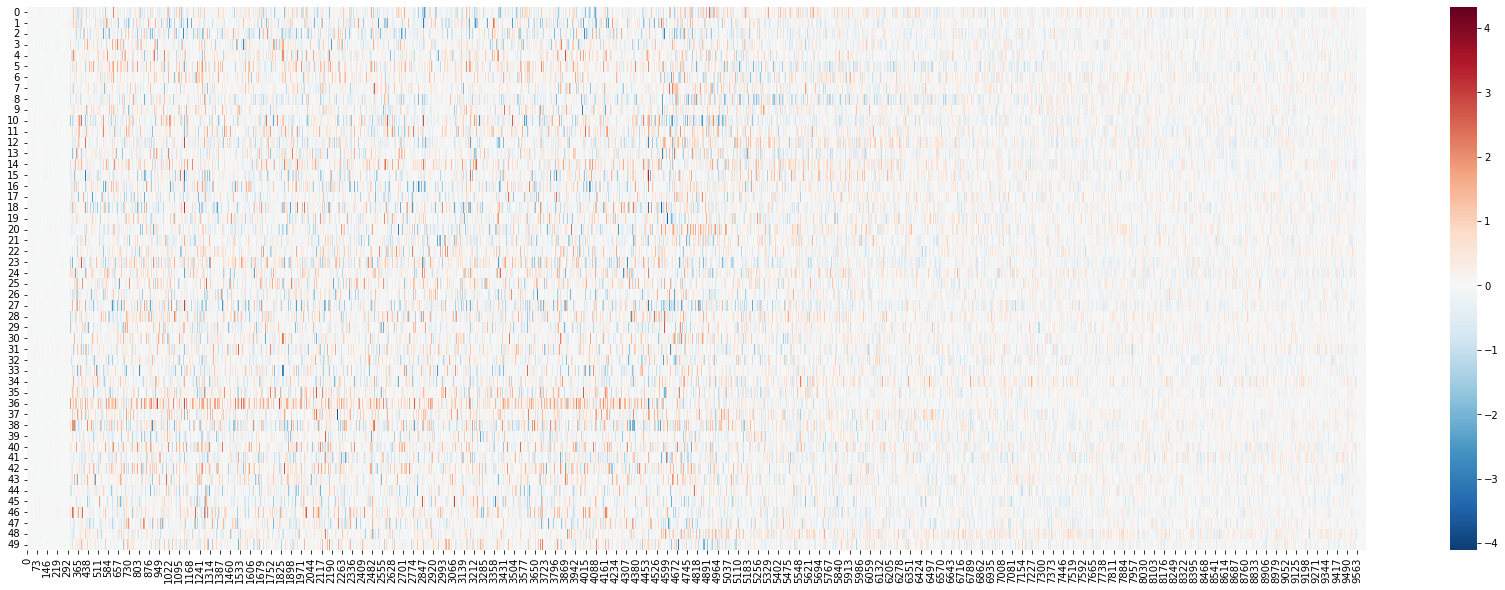

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(model._guide.locs.w.detach().numpy().squeeze(), center=0, cmap='RdBu_r')

(50, 9627) (200, 50)


<AxesSubplot:>

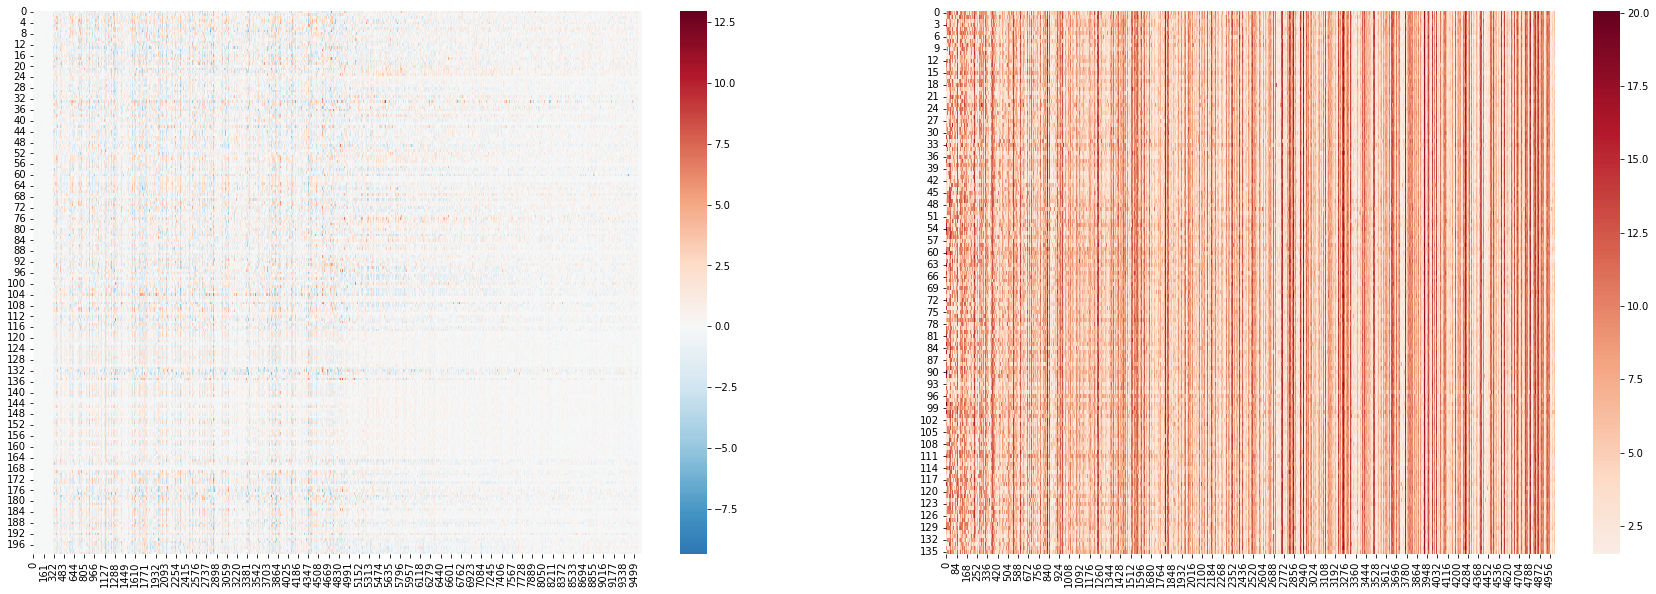

In [7]:
w = model._guide.locs.w.detach().numpy().squeeze()
z = model._guide.locs.z.detach().numpy().squeeze()

print(w.shape, z.shape)

xhat = np.matmul(z, w)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(xhat, center=0, cmap='RdBu_r', ax=ax[0])
sns.heatmap(mdata["mrna"].X, center=0, cmap='RdBu_r', ax=ax[1])